In [ ]:
labels_dictionary = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# **Import Statements**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
import seaborn as sns

# **Loading the image data from ubyte files into numpy arrays**

In [ ]:
#function to convert ubyte files to csv files
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

In [ ]:
#converting ubyte training and testing files to csv files
convert(r"R:\Desktop\train-images-idx3-ubyte", r"R:\Desktop\train-labels-idx1-ubyte",
        r"R:\Desktop\jupyter_fashion_mnist_train.csv", 60000)
convert(r"R:\Desktop\t10k-images-idx3-ubyte", r"R:\Desktop\t10k-labels-idx1-ubyte",
        r"R:\Desktop\jupyter_fashion_mnist_test.csv", 10000)

In [ ]:
#creating training and testing numpy arrays from the contents of the csv files

#training data
train_data = np.loadtxt(r"R:\Desktop\jupyter_fashion_mnist_train.csv", delimiter=",")
train_labels = train_data[:, 0]
train_images = train_data[:, 1:]

#testing data
test_data = np.loadtxt(r"R:\Desktop\jupyter_fashion_mnist_test.csv", delimiter=",")
test_labels = test_data[:, 0]
test_images = test_data[:, 1:]

In [ ]:
#shapes
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

Training images shape: (60000, 784)
Training labels shape: (60000,)
Testing images shape: (10000, 784)
Testing labels shape: (10000,)


In [ ]:
(train_images_reshaped, train_labels_reshaped, test_images_reshaped, test_labels_reshaped) = (train_images.reshape((60000, 28, 28)).astype(np.uint8), train_labels.reshape((60000, 1)).astype(np.uint8), test_images.reshape((10000, 28, 28)).astype(np.uint8), test_labels.reshape((10000, 1)).astype(np.uint8))

C:\Users\rithe\AppData\Local\Temp\ipykernel_6048\3704697174.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(label = f'Label: {labels_dictionary[int(train_labels_reshaped[i])]}')


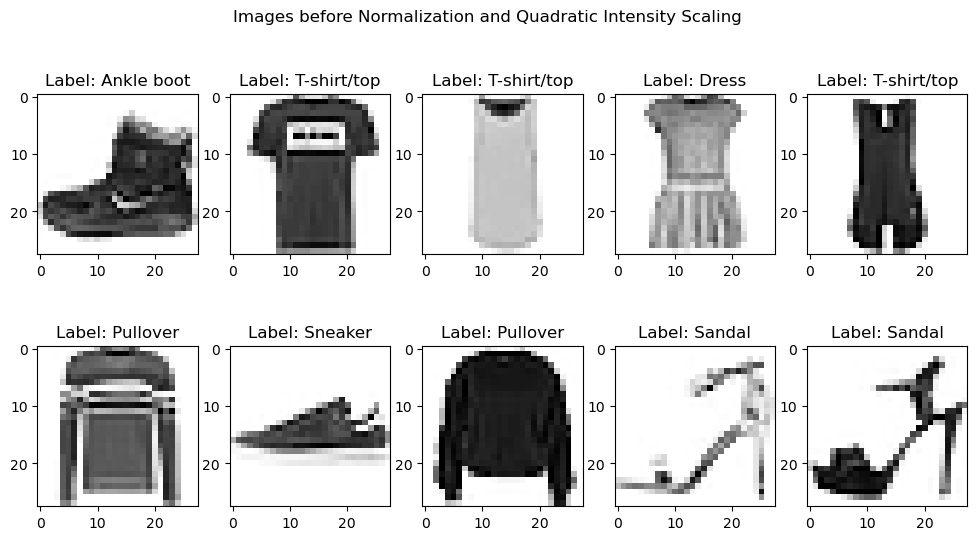

In [ ]:
#plotting 10 sample images and their labels
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    image_array = np.asfarray(train_images_reshaped[i])
    ax = axs[i // 5, i % 5]
    ax.set_title(label = f'Label: {labels_dictionary[int(train_labels_reshaped[i])]}')
    ax.imshow(image_array, cmap='Greys', interpolation='None')
fig.suptitle('Images before Normalization and Quadratic Intensity Scaling')
plt.show()

# **Part 1**

In [ ]:
#normalize pixel values to (0, 1)
train_images_normalized = train_images_reshaped.astype('float32') / 255.0
test_images_normalized = test_images_reshaped.astype('float32') / 255.0

In [ ]:
train_images_normalized.shape

(60000, 28, 28)

In [ ]:
#Quadratic Intensity scaling
def quadratic_intensity_scaling(images):
    scaled_images = np.power(images, 2)
    return scaled_images

train_images_scaled = quadratic_intensity_scaling(train_images_normalized)
test_images_scaled = quadratic_intensity_scaling(test_images_normalized)

C:\Users\rithe\AppData\Local\Temp\ipykernel_6048\4133190348.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(label = f'Label: {labels_dictionary[int(train_labels_reshaped[i])]}')


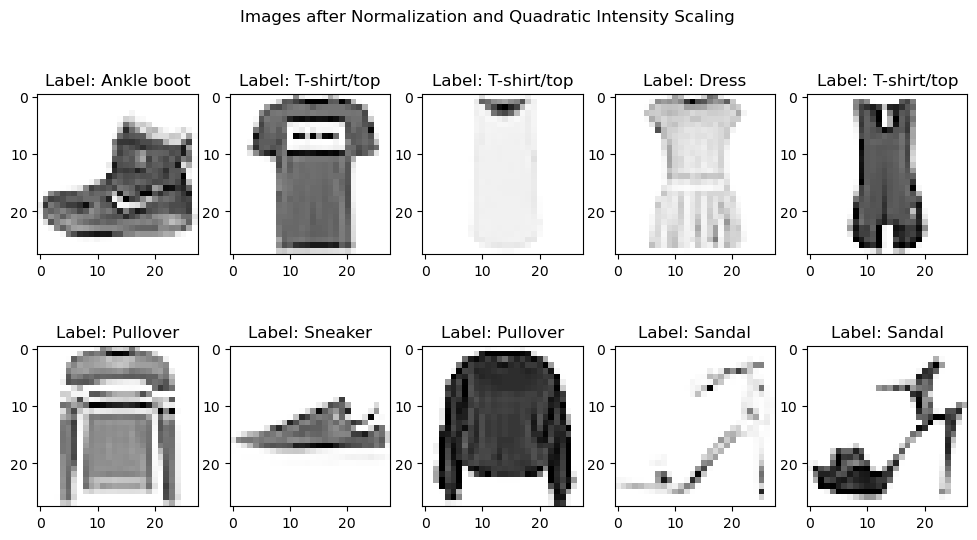

In [ ]:
#plotting 10 images and their labels after normalization and Quadratic Intensity Scaling
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    image_array = np.asfarray(train_images_scaled[i])
    ax = axs[i // 5, i % 5]
    ax.set_title(label = f'Label: {labels_dictionary[int(train_labels_reshaped[i])]}')
    ax.imshow(image_array, cmap='Greys', interpolation='None')
fig.suptitle('Images after Normalization and Quadratic Intensity Scaling')
plt.show()

In [ ]:
#definging augmentations using imgaug

#horizontal flipping
#random cropping
#gaussian blur
#contrast normalization
#random rotations

seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.GaussianBlur(sigma=(0, 1.0)),
    iaa.ContrastNormalization((0.75, 1.5)),
    iaa.Affine(rotate=(-10, 10)),
])

R:\Applications\Anaconda3\Lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [ ]:
#applying augmentations

num_images = train_images_scaled.shape[0]

augmented_images = []
for _ in range(num_images):
    augmented_image = seq.augment_image(train_images_scaled[_])
    augmented_images.append(augmented_image)

# Convert the list of augmented images to a numpy array
augmented_images = np.array(augmented_images)

In [ ]:
augmented_images.shape

(60000, 28, 28)

In [ ]:
#concatenating original and augmented images
combined_images = np.concatenate([train_images_scaled, augmented_images], axis=0)
combined_labels = np.concatenate([train_labels_reshaped, train_labels_reshaped], axis=0)

In [ ]:
print(combined_images.shape)
print(combined_labels.shape)

(120000, 28, 28)
(120000, 1)


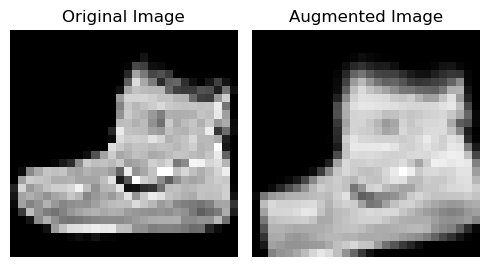

In [ ]:
index = 0

fig, axes = plt.subplots(1, 2, figsize=(5, 3))

# Plot original image
axes[0].imshow(train_images_scaled[index], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot augmented image
axes[1].imshow(combined_images[index+60000], cmap='gray')
axes[1].set_title('Augmented Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#shuffling the augmented images

num_samples = combined_images.shape[0]

random_indices = np.random.permutation(num_samples)

shuffled_images = combined_images[random_indices]
shuffled_labels = combined_labels[random_indices]

C:\Users\rithe\AppData\Local\Temp\ipykernel_6048\368268665.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'Label: {labels_dictionary[int(shuffled_labels[shuffled_index])]}')


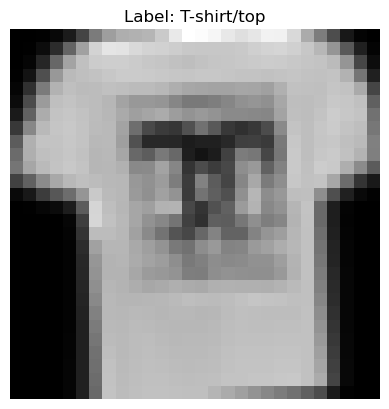

In [ ]:
shuffled_index = 0
plt.imshow(shuffled_images[shuffled_index], cmap='gray')
plt.title(f'Label: {labels_dictionary[int(shuffled_labels[shuffled_index])]}')
plt.axis('off')  # Optional: Hide axis
plt.show()

In [ ]:
#final training and testing data to be fed to the models
(X_train, y_train), (X_test, y_test) = (shuffled_images, shuffled_labels), (test_images_scaled, test_labels_reshaped)

In [ ]:
test_images_scaled.shape

(10000, 28, 28)

# **Part 2**

### **Model 1**

In [ ]:
'''
CNN with:
2 convolutional layers,
2 pooling layers,
1 FC layer with ReLU activation,
1 output layer with softmax activation
'''
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

R:\Applications\Anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#model compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_model1 = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test))

val_accuracy_model1 = history_model1.history['val_accuracy']
print(f"Validation Accuracy for Model 1: {val_accuracy_model1[-1]}")

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7582 - loss: 0.6716 - val_accuracy: 0.8772 - val_loss: 0.3437
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8647 - loss: 0.3639 - val_accuracy: 0.8905 - val_loss: 0.2950
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8843 - loss: 0.3053 - val_accuracy: 0.9005 - val_loss: 0.2712
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9022 - loss: 0.2620 - val_accuracy: 0.9074 - val_loss: 0.2603
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9137 - loss: 0.2312 - val_accuracy: 0.9065 - val_loss: 0.2699
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9218 - loss: 0.2076 - val_accuracy: 0.9124 - val_loss: 0.2712
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9312 - loss: 0.1823 - val_accuracy: 0.9065 - val_loss: 0.2942
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9400 - loss: 0

# **Part 3**

### **Model 2**

In [ ]:
'''
CNN with:
2 convolutional layers,
2 pooling layers,
1 FC layer with ReLU activation,
1 output layer with softmax activation,
Batch Normalization and
Droput layers
'''
model2= models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [ ]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,418 (880.54 KB)

 Trainable params: 225,226 (879.79 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
#model compilation
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#model training
history_model2 = model2.fit(X_train, y_train, epochs=10, callbacks=[reduce_lr, early_stop], batch_size=64, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6707 - loss: 0.9771 - val_accuracy: 0.8626 - val_loss: 0.3846 - learning_rate: 0.0010
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8017 - loss: 0.5395 - val_accuracy: 0.8773 - val_loss: 0.3379 - learning_rate: 0.0010
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8257 - loss: 0.4751 - val_accuracy: 0.8801 - val_loss: 0.3270 - learning_rate: 0.0010
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8349 - loss: 0.4465 - val_accuracy: 0.8857 - val_loss: 0.3136 - learning_rate: 0.0010
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8438 - loss: 0.4279 - val_accuracy: 0.8866 - val_loss: 0.3070 - learning_rate: 0.0010
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8505 - loss: 0.4064 - val_accuracy: 0.8918 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accura

# **Comparision of Models**

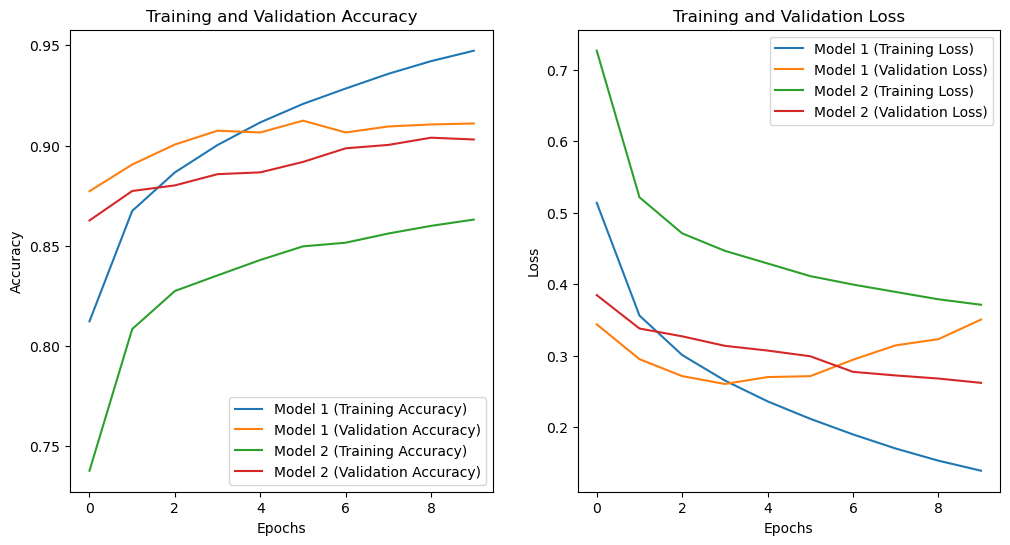

In [ ]:
#training history metrics for model 1
acc_model1 = history_model1.history['accuracy']
val_acc_model1 = history_model1.history['val_accuracy']
loss_model1 = history_model1.history['loss']
val_loss_model1 = history_model1.history['val_loss']

#training history metrics for model 1
acc_model2 = history_model2.history['accuracy']
val_acc_model2 = history_model2.history['val_accuracy']
loss_model2 = history_model2.history['loss']
val_loss_model2 = history_model2.history['val_loss']

#accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc_model1, label='Model 1 (Training Accuracy)')
plt.plot(val_acc_model1, label='Model 1 (Validation Accuracy)')
plt.plot(acc_model2, label='Model 2 (Training Accuracy)')
plt.plot(val_acc_model2, label='Model 2 (Validation Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

#loss curves
plt.subplot(1, 2, 2)
plt.plot(loss_model1, label='Model 1 (Training Loss)')
plt.plot(val_loss_model1, label='Model 1 (Validation Loss)')
plt.plot(loss_model2, label='Model 2 (Training Loss)')
plt.plot(val_loss_model2, label='Model 2 (Validation Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


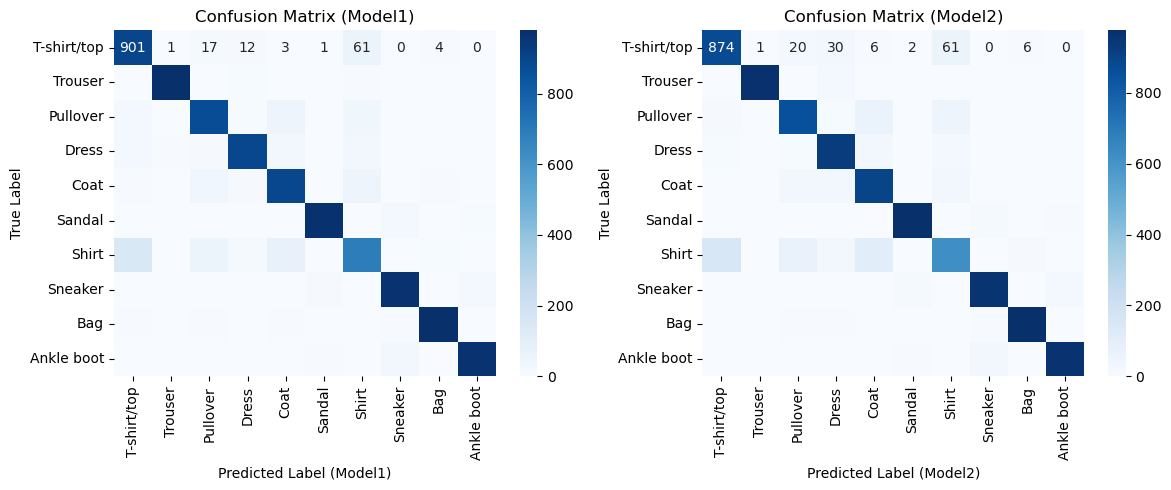

In [ ]:
#confusion matrices for both the models' predictions
y_pred_probabilities_model1 = model.predict(X_test)
y_pred_model1 = np.argmax(y_pred_probabilities_model1, axis=1)

conf_matrix_model1 = confusion_matrix(y_test, y_pred_model1)

y_pred_probabilities_model2 = model2.predict(X_test)
y_pred_model2 = np.argmax(y_pred_probabilities_model2, axis=1)

conf_matrix_model2 = confusion_matrix(y_test, y_pred_model2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_matrix_model1, annot=True, fmt="d", cmap="Blues", ax=axes[0], xticklabels=labels_dictionary.values(), yticklabels=labels_dictionary.values())
axes[0].set_xlabel('Predicted Label (Model1)')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix (Model1)')

sns.heatmap(conf_matrix_model2, annot=True, fmt="d", cmap="Blues", ax=axes[1],
            xticklabels=labels_dictionary.values(), yticklabels=labels_dictionary.values())
axes[1].set_xlabel('Predicted Label (Model2)')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix (Model2)')

plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\rithe\AppData\Local\Temp\ipykernel_6048\3567712591.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_label = class_names[int(y_test[i])]


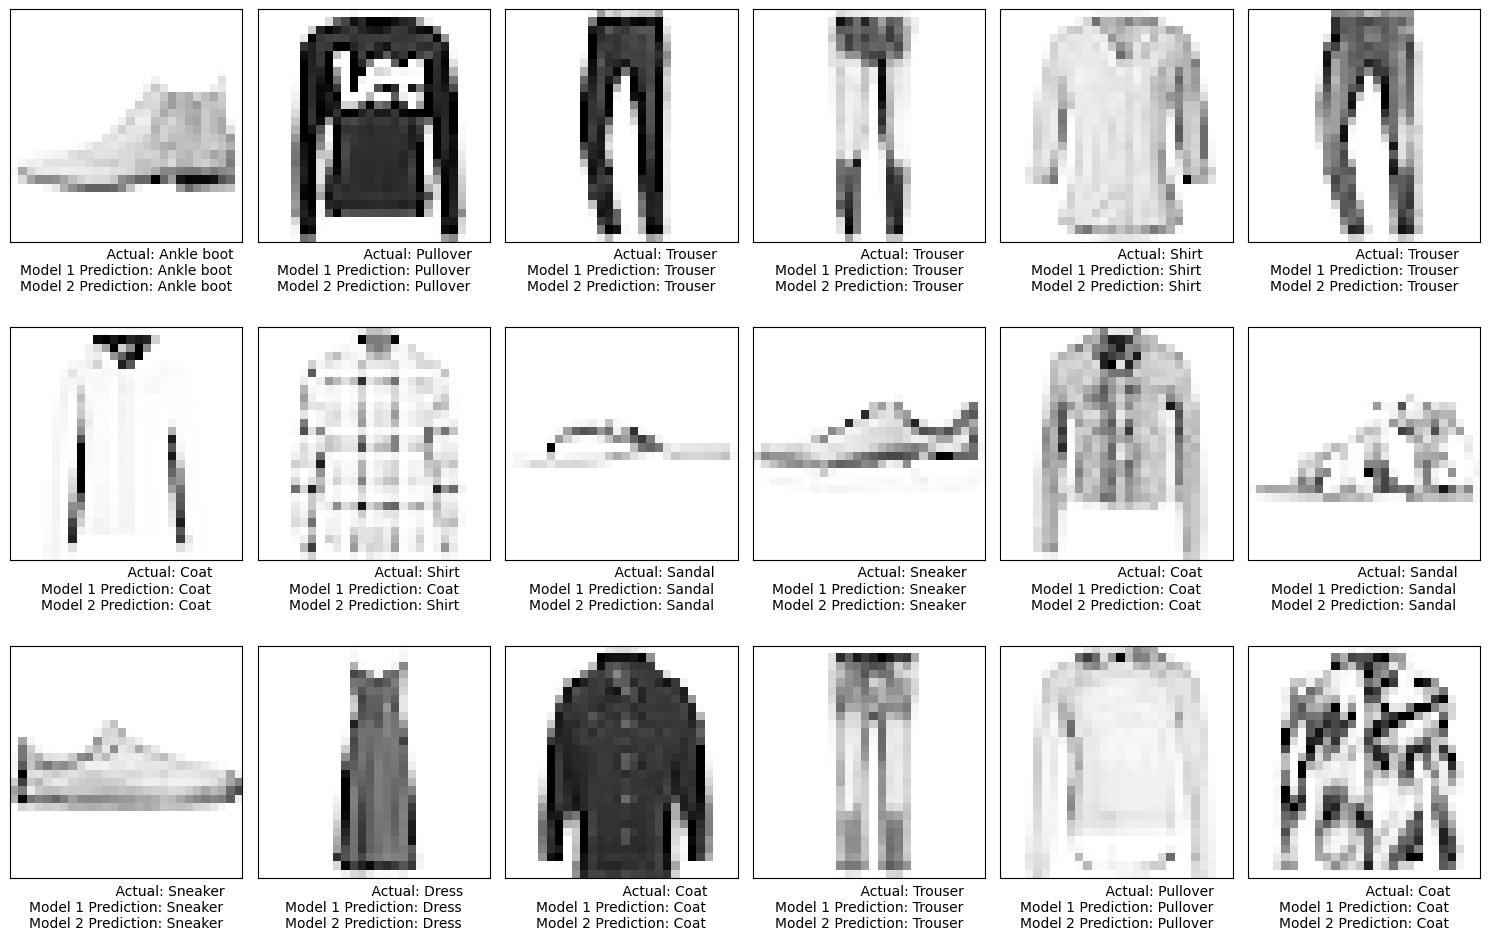

In [ ]:
#visualizing the predictions of the two models

y_pred_model2 = model2.predict(X_test)
y_pred_labels_model2 = np.argmax(y_pred_model2, axis=1)

plt.figure(figsize=(15, 10))
for i in range(18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(X_test[i], cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    actual_label = class_names[int(y_test[i])]
    predicted_label_model1 = class_names[y_pred_labels[i]]
    predicted_label_model2 = class_names[y_pred_labels_model2[i]]
    plt.xlabel(f'                    Actual: {actual_label}\nModel 1 Prediction: {predicted_label_model1}\nModel 2 Prediction: {predicted_label_model2}')
plt.tight_layout()
plt.show()

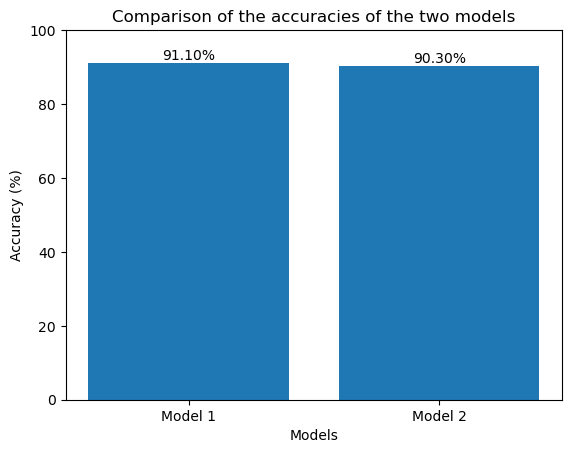

In [ ]:
#comparision of accuracy of the two models
accuracy1_percent = accuracy1 * 100
accuracy2_percent = accuracy2 * 100

labels = ['Model 1', 'Model 2']
accuracies_percent = [accuracy1_percent, accuracy2_percent]

plt.bar(labels, accuracies_percent)
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of the accuracies of the two models')

for i, accuracy_percent in enumerate(accuracies_percent):
    plt.text(i, accuracy_percent, f'{accuracy_percent:.2f}%', ha='center', va='bottom')

plt.ylim(0, 100)
plt.show()